In [1]:
### Neural Network Model
### Monthly prediction
## no shuffle of data
### no Lookback

In [2]:
import sys
sys.path.append('/home/jovyan/work/')
sys.path.append('/home/jovyan/work/src')
sys.path.append('/home/jovyan/work/src/data')
sys.path.append('/home/jovyan/work/src/data_explore')
sys.path.append('/home/jovyan/work/src/features')
sys.path.append('/home/jovyan/work/src/models')
sys.path.append('/home/jovyan/work/src/analysis')


In [3]:
print(sys.path)

['/home/jovyan/work/notebooks', '/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '', '/opt/conda/lib/python3.11/site-packages', '/home/jovyan/work/', '/home/jovyan/work/src', '/home/jovyan/work/src/data', '/home/jovyan/work/src/data_explore', '/home/jovyan/work/src/features', '/home/jovyan/work/src/models', '/home/jovyan/work/src/analysis']


In [4]:
from src import data,data_explore,features
from data import create_input_data
from data_explore import explore_util
from features import build_features
from models import train_model,predict_model
from analysis import analyze_pred

In [5]:
def get_jobs_in_range(dfq,start,end):
    df1=dfq.query('submit >= @start and submit < @end')
    return df1

In [6]:
df_arr={}
df_jan = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Jan2022_1Feb2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['jan'] = df_jan
df_feb_aug = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Feb2022_1Aug2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['feb']= get_jobs_in_range(df_feb_aug,"2022-02-01","2022-03-01")
df_arr['march']= get_jobs_in_range(df_feb_aug,"2022-03-01","2022-04-01")
df_arr['april']= get_jobs_in_range(df_feb_aug,"2022-04-01","2022-05-01")
df_arr['may'] = get_jobs_in_range(df_feb_aug,"2022-05-01","2022-06-01")
df_arr['june'] = get_jobs_in_range(df_feb_aug,"2022-06-01","2022-07-01")
df_arr['july'] = get_jobs_in_range(df_feb_aug,"2022-07-01","2022-08-01")
df_arr['august'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Aug2022_1Sept2022normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['sept'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Sept2022_1Oct2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['oct'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Oct2022_1Nov2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['nov'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Nov2022_1Dec2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['dec'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Dec2022_1Jan2023_normal_sorted.csv", parse_dates_col=[4,5,6])

In [8]:
def train_test_data(month):
    X_historydata = df_arr[month]
    ## remove default columns
    df = build_features.remove_default_cols(df_arr[month])
    Y_waittimedata = df['queue_minutes']
    X_historydata= build_features.remove_cols(df,['queue_minutes','run_minutes'])
    return X_historydata, Y_waittimedata

In [9]:
from importlib import reload
reload(train_model)
def train_model_NN(X_historydata_norm, Y_waittimedata_train):
    epochs=500
    batch_size=32
    validation_spilt=0.2
    model = train_model.create_default_model(input_shape=7)
    early_stopping_cb = train_model.set_early_stopping()
    model, hist = train_model.train_model_no_shuffle(X_historydata_norm, Y_waittimedata_train, model, early_stopping_cb,epochs=epochs, batch_size=batch_size, validation_spilt=0.2)
    return model, hist

In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def predict_evaluate(model,scaler,X_historydata_test,Y_waittimedata_test):
    y_pred=model.predict(scaler.transform(X_historydata_test))
    y_pred = np.where(y_pred<0,0,y_pred)
    r2s = r2_score(Y_waittimedata_test.to_numpy(),y_pred)
    mse = mean_squared_error(Y_waittimedata_test.to_numpy(),y_pred,squared=False)
    mae = mean_absolute_error(Y_waittimedata_test.to_numpy(),y_pred)
    return y_pred, r2s, mse, mae

In [11]:
from sklearn.linear_model import LinearRegression
from importlib import reload
import numpy as np
reload(analyze_pred)
reload(build_features)
train_months=['jan','feb','march','april','may','june','july','august','sept','oct']
predict_months=['feb','march','april','may','june','july','august','sept','oct','nov']
results=[]
for i in range(0,10):
    result = {}
    result['train_month']= train_months[i]
    result['predict_month']= predict_months[i]
    X_historydata_train, Y_waittimedata_train = train_test_data(train_months[i])
    X_historydata_test, Y_waittimedata_test = train_test_data(predict_months[i])
    X_historydata_norm, scaler = build_features.standardization(X_historydata_train)
    model, hist = train_model_NN(X_historydata_norm, Y_waittimedata_train)
    y_pred, r2s, mse, mae = predict_evaluate(model,scaler,X_historydata_test,Y_waittimedata_test)
    #provision_time = 20
    provision_time = 45 
    tolerance_factor = 3
    provision_time, n_scheduled, n_missed, no_missed, wrongly_scheduled, t_num = analyze_pred.analysis_short(0,Y_waittimedata_test.shape[0], Y_waittimedata_test, y_pred.ravel(),
                                                                                                          provision_time=provision_time, tolerance_factor=tolerance_factor)
    
    result['ideally_sched'] = n_scheduled
    result['missed'] = n_missed

    result['wrongly_sched'] = wrongly_scheduled
    result['total_num'] = t_num
    result['%_wrongly_sched'] = (wrongly_scheduled/t_num)*100
    result['%_ideally_sched'] = (n_scheduled/t_num)*100
    result['%_missed_oppor.'] = (n_missed/n_scheduled)*100
    result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100
    result['r2s'] = r2s
    result['mse'] = mse
    result['mae'] = mae
    result['provision_time'] = provision_time
    #result['model_score'] = model_score
    #result['model'] = lreg
    result['y_pred'] = y_pred
    #result['not_missed'] = no_missed
    #result['provision_time'] = provision_time
    results.append(result)
    #print(result)
    #print("\n")


Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 30)                240       
                                                                 
 Hidden2 (Dense)             (None, 100)               3100      
                                                                 
 Hidden3 (Dense)             (None, 100)               10100     
                                                                 
 Output (Dense)              (None, 1)                 101       
                                                                 
Total params: 13,541
Trainable params: 13,541
Non-trainable params: 0
_________________________________________________________________
None
1127/1127 [==============================] - 0s 396us/step
Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output 

/tmp/ipykernel_2999/2280644773.py:32: RuntimeWarning: invalid value encountered in long_scalars
  result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100


Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 30)                240       
                                                                 
 Hidden2 (Dense)             (None, 100)               3100      
                                                                 
 Hidden3 (Dense)             (None, 100)               10100     
                                                                 
 Output (Dense)              (None, 1)                 101       
                                                                 
Total params: 13,541
Trainable params: 13,541
Non-trainable params: 0
_________________________________________________________________
None
2466/2466 [==============================] - 1s 396us/step
Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output 

/tmp/ipykernel_2999/2280644773.py:32: RuntimeWarning: invalid value encountered in long_scalars
  result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100


In [12]:
reload(analyze_pred)
rdf = analyze_pred.add_all_to_df(results)

In [13]:
rdf

,train_month,predict_month,ideally_sched,missed,wrongly_sched,total_num,%_wrongly_sched,%_ideally_sched,%_missed_oppor.,t_wrong_sched_%,r2s,mse,mae,provision_time,y_pred
0,jan,feb,12854,6016,4343,36043,12.049496,35.662958,46.802552,38.842680,0.015544,786.046662,254.145335,45,"[[76.46564], [48.99321], [39.723034], [76.1078..."
1,feb,march,16178,6,24182,44846,53.922312,36.074566,0.037087,59.924667,0.033845,495.346671,244.550872,45,"[[234.0281], [234.0281], [234.49156], [234.955..."
2,march,april,4253,3322,2609,62427,4.179281,6.812757,78.109570,73.700565,-0.019654,221.383471,43.842445,45,"[[0.0], [25.934708], [233.14127], [233.73523],..."
3,april,may,1990,1873,1,55544,0.001800,3.582745,94.120603,0.847458,0.029438,258.515834,37.935083,45,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
4,may,june,7455,3234,6784,57031,11.895285,13.071838,43.380282,61.644707,0.012949,196.866906,103.956189,45,"[[110.28403], [105.453], [106.48427], [112.019..."
5,june,july,2840,143,12164,67325,18.067583,4.218344,5.035211,81.851827,0.089786,673.861462,173.120924,45,"[[14.342448], [4.3646717], [4.3646717], [10.95..."
6,july,august,9048,9048,0,69801,0.000000,12.962565,100.000000,NaN,-0.030018,582.206331,130.693237,45,"[[48.6324], [48.731266], [48.830128], [48.9289..."
7,august,sept,4056,3931,5664,78908,7.177979,5.140163,96.918146,97.840732,-0.098080,500.293899,113.650902,45,"[[781.2834], [781.2834], [0.0], [0.0], [0.0], ..."
8,sept,oct,2896,2862,25,41664,0.060004,6.950845,98.825967,42.372881,-0.007312,270.010188,45.515865,45,"[[90.08393], [90.32565], [101.02092], [101.020..."
9,oct,nov,2215,2215,0,55530,0.000000,3.988835,100.000000,NaN,-0.023325,113.776008,20.037211,45,"[[5.2565417], [3.6199148], [0.0], [0.0], [0.51..."


In [14]:
# write to file
from pathlib import Path  
filepath = Path('../data/processed/month_prediction_nolookback_nn_anon_jan-nov22_prov45.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
rdf.to_csv(filepath,index=False)

Text(0, 0.5, 'Total Number of Wrong Scheduled Jobs')

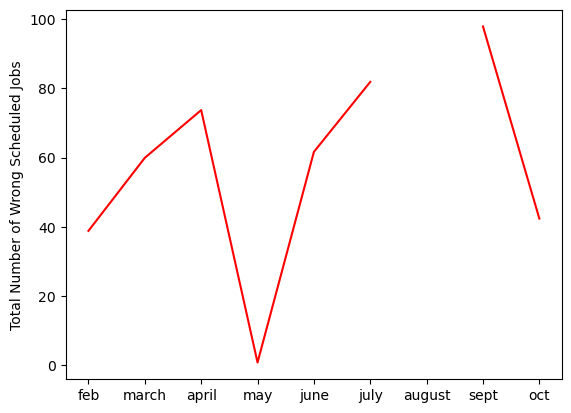

In [15]:
import matplotlib.pyplot as plt
t_wrong_sched= [] 


for i in range(0,10):
    t_wrong_sched.append(results[i]['t_wrong_sched_%'])
plt.plot(predict_months,t_wrong_sched,'r')
plt.ylabel('Total Number of Wrong Scheduled Jobs')

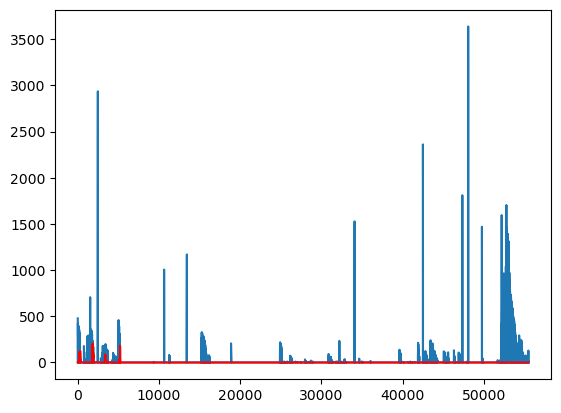

In [58]:
plt.plot(df_arr['nov']['queue_minutes'].to_numpy())
plt.plot(results[9]['y_pred'],'r')

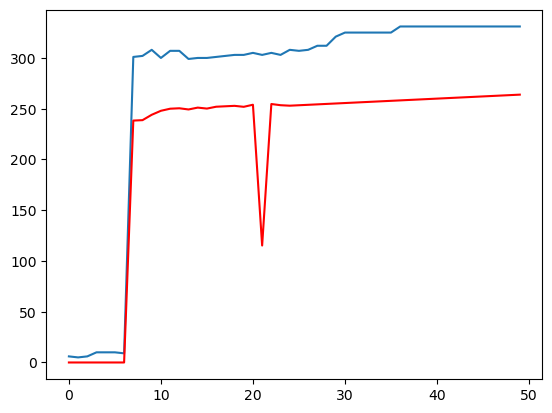

In [41]:

plt.plot(df_arr['april']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[2]['y_pred'][150:200],'r')

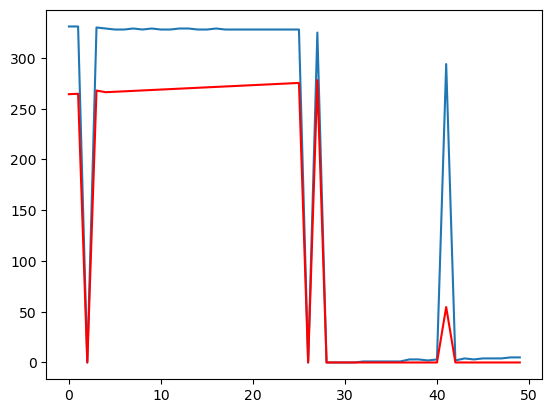

In [42]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[200:250])
plt.plot(results[2]['y_pred'][200:250],'r')

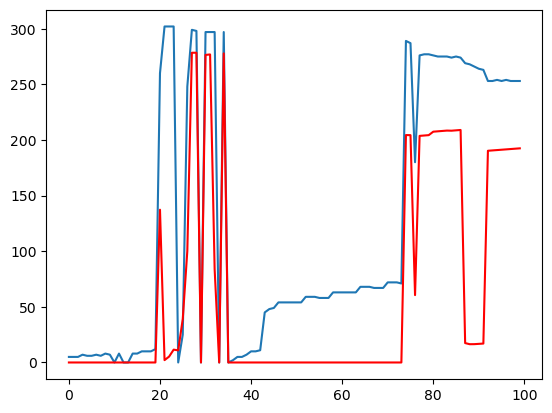

In [43]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[250:350])
plt.plot(results[2]['y_pred'][250:350],'r')

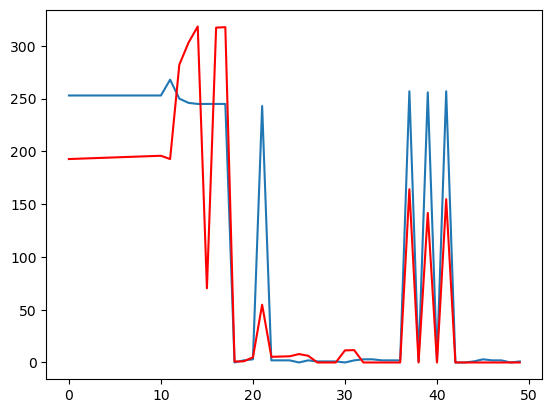

In [44]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[350:400])
plt.plot(results[2]['y_pred'][350:400],'r')

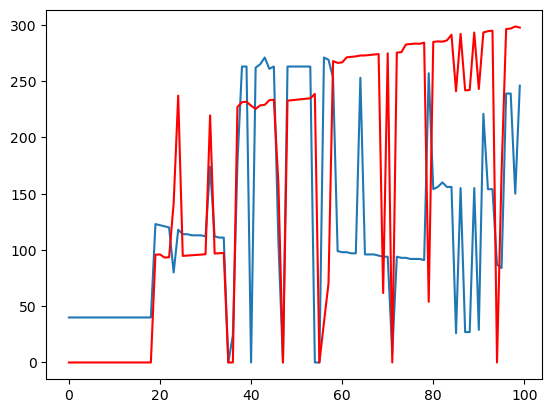

In [45]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[1250:1350])
plt.plot(results[2]['y_pred'][1250:1350],'r')

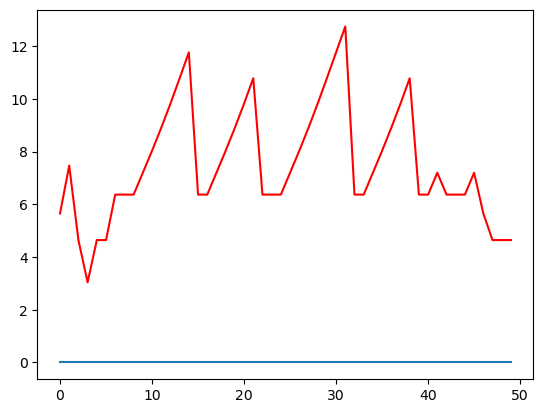

In [46]:
import matplotlib.pyplot as plt
plt.plot(df_arr['july']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[5]['y_pred'][150:200],'r')

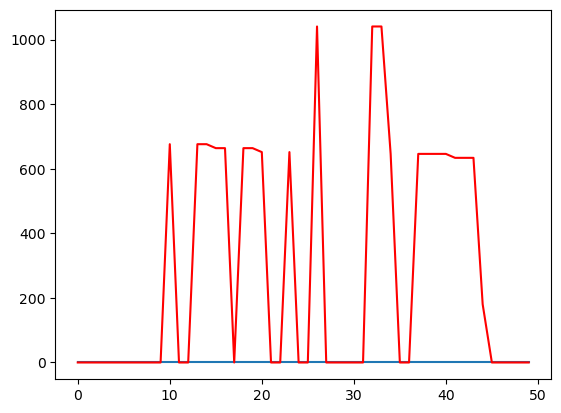

In [24]:
import matplotlib.pyplot as plt
plt.plot(df_arr['sept']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[7]['y_pred'][150:200],'r')